# Przetwarzanie języka naturalnego – lab7
## Mateusz Kocot

In [1]:
import os
from collections import defaultdict, Counter
import requests
import time
import pickle
import regex as re
import asyncio
from zipfile import ZipFile
from xml.etree import ElementTree as ETree
from dataclasses import dataclass
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt

import lpmn_client as lpmn

from IPython.display import display, HTML

In [2]:
DATA_DIR = '../ustawy'
N_BILLS = 50

# Task 4

In [3]:
dataset = []

for file_name in os.listdir(DATA_DIR):
    with open(f'{DATA_DIR}/{file_name}', 'r', encoding='UTF-8') as file:
        bill = file.read()
    dataset.append((file_name, bill))
    
dataset = sorted(dataset, key=lambda x: len(x[1]), reverse=True)[:N_BILLS]
file_names, dataset = zip(*dataset)

# Task 5 and 6

## Code + example

In [4]:
example = 'Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych Am3ryki. Ali kot wabi się Ala.'

In [5]:
def lemmatize(text: str) -> list[tuple[str, str]]:
    lemmatized_text = sum(requests.post('http://localhost:9003/?output_format=jsonl', data=text.encode('utf-8')).json(), [])
    lemmatized_tokens = list(map(lambda x: (x[1], x[2].split(':', 1)[0]), lemmatized_text))
    return lemmatized_tokens

lemmatized_example = lemmatize(example)
print(lemmatized_example[8:14])

[('i', 'conj'), ('Stany', 'subst'), ('Zjednoczony', 'adj'), ('Am3ryki', 'subst'), ('.', 'interp'), ('Ali', 'subst')]


In [6]:
def split_sentences(text: list[tuple[str, str]], skip_first_word=True) -> list[list[str]]:
    result = []
    left = 0 if not skip_first_word else 1
    right = 0
    while right < len(text):
        if text[right] == ('.', 'interp'):
            if right > left:
                result.append([a[0] for a in text[left:right]])
            left = right + 1 if not skip_first_word else right + 2
        right += 1
    return result

split_example = split_sentences(lemmatized_example)
print(split_example)

[['w', 'Kraków', 'mieć', 'miejsce', 'spotkanie', 'prezydent', 'Polska', 'i', 'Stany', 'Zjednoczony', 'Am3ryki'], ['kot', 'wabić', 'się', 'Ala']]


In [7]:
# - Include words with only the first character uppercased to avoid Roman numbers, etc. 
# - Skip short (one- and two-letter) words
def is_capitalized(word: str) -> bool:
    return len(word) > 2 and word[0].isupper() and all(map(str.islower, word[1:]))

def is_word(word: str) -> bool:
    return not re.match(r'.*[^\p{L}]', word)

def identify_expressions(text: list[list[str]]) -> list[list[str]]:
    expressions = defaultdict(int)
    for sentence in text:
        left = 0
        right = 0
        while right < len(sentence):
            if is_word(sentence[right]) and is_capitalized(sentence[right]): # Include only words
                right += 1
            else:
                if right > left:
                    expressions[tuple(sentence[left:right])] += 1
                right += 1
                left = right

        if right > left:
            expressions[tuple(sentence[left:right])] += 1
                
    return Counter(expressions)

print(identify_expressions(split_example))

Counter({('Kraków',): 1, ('Polska',): 1, ('Stany', 'Zjednoczony'): 1, ('Ala',): 1})


## Process the bills

#### 1. Lemmatize
- Used https://hub.docker.com/r/djstrong/krnnt/
- Elapsed time: 7 min

In [8]:
# start = time.time()
# for i, bill in enumerate(dataset):
#     # if i % 5 == 0:
#     print(f'Processing bill no {i}')
#     lemmatized_text = lemmatize(bill)
#     with open(f'lemmatized_corpus/bill_{i}.pkl', 'wb') as file:
#         pickle.dump(lemmatized_text, file)
# print(f'Elapsed {time.time() - start:0.2f} s')

In [9]:
lemmatized_dataset = []
for i in range(N_BILLS):
    with open(f'lemmatized_corpus/bill_{i}.pkl', 'rb') as file:
        lemmatized_dataset.append(pickle.load(file))

#### 2. The rest

In [10]:
def process_lem(lem_text):
    return identify_expressions(split_sentences(lem_text))

expressions_freq = sum((process_lem(text) for text in lemmatized_dataset), Counter())

In [11]:
expressions_freq.most_common()[:50]

[(('Rzeczpospolita',), 958),
 (('Kas',), 166),
 (('Polska',), 83),
 (('Warszawa',), 75),
 (('Art',), 58),
 (('Republika',), 29),
 (('Kasa',), 24),
 (('Wojewoda',), 20),
 (('Rzeczpospolita', 'Polska'), 16),
 (('Starosta',), 14),
 (('Nych',), 12),
 (('Celsjusz',), 11),
 (('Gdańsk',), 10),
 (('Aza',), 9),
 (('Kasia',), 9),
 (('Organa',), 8),
 (('Polski',), 8),
 (('Papier',), 7),
 (('Bank',), 7),
 (('Bóg',), 7),
 (('Londyn',), 7),
 (('Bor',), 7),
 (('Zdrowotny',), 7),
 (('Naturalny',), 6),
 (('Szczecin',), 6),
 (('Poznań',), 6),
 (('Lublin',), 6),
 (('Wrocław',), 6),
 (('Katowice',), 6),
 (('Kraków',), 6),
 (('Farmaceutyczny',), 6),
 (('Bruksela',), 6),
 (('Celny',), 6),
 (('Wyroba',), 6),
 (('Wania',), 6),
 (('Joulie',), 6),
 (('Zatoka',), 6),
 (('Danych',), 6),
 (('Solidarność',), 5),
 (('Internet',), 5),
 (('Łódź',), 4),
 (('Nega',), 4),
 (('Najwyższemu',), 4),
 (('Rodek',), 4),
 (('Giełd',), 4),
 (('Gaza',), 4),
 (('Naprawa',), 4),
 (('Legnica',), 4),
 (('Wałbrzych',), 4),
 (('Bydgoszc

# Task 7

### Send requests

In [12]:
# async def lpmn_process_file(file_name):
#     task = lpmn.Task('any2txt|wcrft2|liner2({"model":"n82"})')
    
#     file_id = lpmn.upload_file(f'{DATA_DIR}/{file_name}')
#     output_file_id = task.run(file_id)
#     lpmn.download_file(output_file_id, output_path='./lpmn_corpus/downloaded/', filename=f'{file_name[:-4]}.zip')
    
#     with ZipFile(f'./lpmn_corpus/downloaded/{file_name[:-4]}.zip', 'r') as obj:
#         obj.extractall('./lpmn_corpus/processed/')

# await asyncio.gather(*[lpmn_process_file(f) for f in file_names])

### Process responses

In [13]:
ner_xml_dataset = []
for file_name in os.listdir('./lpmn_corpus/processed/'):
    tree = ETree.parse(f'./lpmn_corpus/processed/{file_name}')
    ner_xml_dataset.append(tree)

In [14]:
@dataclass
class Token:
    orth: str
    base: str
    ctag: str
    
@dataclass
class Annotation:
    category: str
    tokens: list[Token]
    lemma: str
    
def parse_sentence(sentence):
    channels = defaultdict(lambda: defaultdict(list))
    for token in sentence.iter('tok'):
        t = Token(token.find('orth').text, token.find('lex/base').text, token.find('lex/ctag').text)
        for channel in token.iter('ann'):
            idx = int(channel.text)
            chan = channel.attrib["chan"]       
            if idx > 0:
                channels[chan][idx].append(t)
                
    annotations = []
    for chan, group in channels.items():
        for tokens in group.values():
            lemma = ' '.join((t.orth for t in tokens))
            annotations.append(Annotation(chan, tokens, lemma))
        
    return annotations

In [15]:
ner_dataset = []
for file_name in os.listdir('./lpmn_corpus/processed/'):
    tree = ETree.parse(f'./lpmn_corpus/processed/{file_name}')
    annotations = []
    for sentence in tree.iter('sentence'):
        annotations.append(parse_sentence(sentence))
    ner_dataset.append(annotations)

In [16]:
pprint(ner_dataset[0][92][:2])

[Annotation(category='nam_loc_gpe_country',
            tokens=[Token(orth='Polsce', base='Polska', ctag='subst:sg:dat:f')],
            lemma='Polsce'),
 Annotation(category='nam_loc_gpe_country',
            tokens=[Token(orth='Rzeczypospolitej',
                          base='rzeczpospolita',
                          ctag='subst:sg:gen:f'),
                    Token(orth='Polskiej',
                          base='polski',
                          ctag='adj:sg:gen:f:pos')],
            lemma='Rzeczypospolitej Polskiej')]


# Task 8

In [17]:
ann_coarse_counter = defaultdict(int)
ann_coarse_entity_counter = defaultdict(lambda: defaultdict(int))
for annotations in ner_dataset:
    for annotations_sentence in annotations:
        for ann in annotations_sentence:
            cat = re.match('[^_]*_[^_]*', ann.category).group()
            ann_coarse_counter[cat] += 1
            ann_coarse_entity_counter[cat][ann.lemma] += 1
            
ann_coarse_counter = dict(sorted(ann_coarse_counter.items(), key=lambda x: x[1], reverse=True))

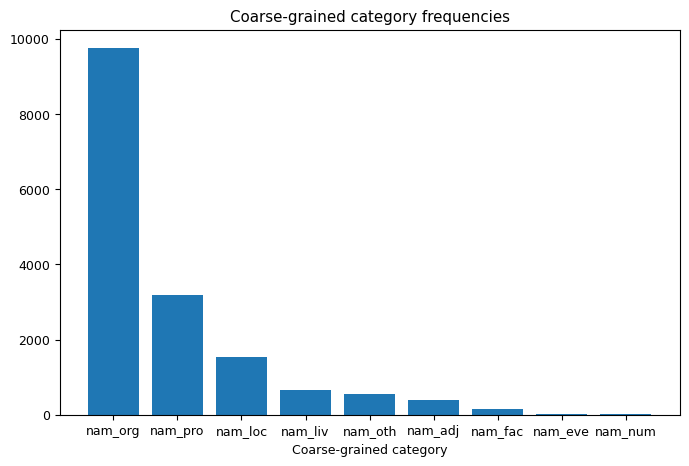

In [18]:
plt.figure(figsize=(8, 5))
plt.rc('font', size=9)

plt.bar(ann_coarse_counter.keys(), ann_coarse_counter.values())
plt.title('Coarse-grained category frequencies')
plt.xlabel('Coarse-grained category')

plt.show()

# Task 9

In [19]:
for cat in ann_coarse_counter.keys():
    display(HTML(f'<h4>{cat}</h4>'))
    counter = Counter(ann_coarse_entity_counter[cat])
    for entity in counter.most_common()[:10]:
        print(entity)

('Skarbu Państwa', 295)
('Unii Europejskiej', 291)
('Rada Ministrów', 261)
('Państwowej Straży Pożarnej', 239)
('Minister Sprawiedliwości', 233)
('Prezes Rady Ministrów', 213)
('Minister Obrony Narodowej', 162)
('Minister Finansów', 152)
('Urzędu Ochrony Państwa', 137)
('EFTA', 114)


('Dz . U .', 1534)
('Dz . Urz', 80)
('Ordynacja podatkowa', 71)
('Kodeksu karnego', 64)
('Monitor Polski', 62)
('Spraw Wewnętrznych', 51)
('Kodeksu postępowania administracyjnego', 35)
('Kodeksu postępowania karnego', 33)
('Kodeksu postępowania cywilnego', 32)
('Natura 2000', 26)


('Rzeczypospolitej Polskiej', 812)
('Rzeczpospolita Polska', 52)
('Polsce', 51)
('Rzeczpospolitą Polską', 39)
('Warszawie', 32)
('Warszawy', 20)
('Nawóz', 19)
('Warszawa', 16)
('Konfederacji Szwajcarskiej', 11)
('Polską', 10)


('Kasa Chorych', 51)
('Straży Granicznej', 36)
('Sił Zbrojnych', 24)
('Kasy Chorych', 21)
('Art', 18)
('Pana', 18)
('Gospodarki Żywnościowej', 16)
('Krajowego Depozytu', 15)
('Pan', 15)
('Kas Chorych', 13)


('zł', 293)
('euro', 89)
('złotych', 41)
('EURO', 29)
('PESEL', 14)
('BAT', 12)
('PLN', 10)
('Minister Edukacji Narodowej', 8)
('ECU', 7)
('NIP', 7)


('polski', 116)
('polskiej', 30)
('polskiego', 16)
('Wojewódzki', 16)
('polskim', 10)
('polska', 9)
('polską', 7)
('polskich', 7)
('mazowiecki', 7)
('europejskiej', 5)


('Inspektor Nadzoru Wewnętrznego', 49)
('Komendant Główny', 16)
('Straży Granicznej', 11)
('Mangan', 8)
('Obrony Narodowej', 6)
('Krajowego Rejestru Karnego', 5)
('Molibden', 4)
('Zatoki Gdańskiej', 4)
('Zasłużonego Dawcy Przeszczepu', 4)
('Mn', 3)


('EURO', 5)
('Monitorze Sądowym', 2)
('Przejściowego Planu Krajowego', 2)
('Oddział 2 Tranzyt', 1)
('X . Opieka domowa nad dziećmi', 1)
('II wojny światowej', 1)
('TOP SECRET', 1)
('Narodowy Bank Polski', 1)
('Międzynarodowe Standardy Rachunkowości', 1)
('Generalny Konserwator Zabytków', 1)


('1', 13)
('112', 1)


# Task 10

In [20]:
entity_counter = defaultdict(int)
for annotations in ner_dataset:
    for annotations_sentence in annotations:
        for ann in annotations_sentence:
            entity_counter[(ann.lemma, ann.category)] += 1
            
entity_counter = Counter(entity_counter)

In [21]:
e_mc = entity_counter.most_common()[:50]
pd.DataFrame(list(zip([e[0][0] for e in e_mc], [e[0][1] for e in e_mc], [e[1] for e in e_mc])), columns=['entity', 'fine-coarsed type', 'count']).set_index('entity')

,fine-coarsed type,count
entity,,
Dz . U .,nam_pro_media_periodic,1534
Rzeczypospolitej Polskiej,nam_loc_gpe_country,812
Skarbu Państwa,nam_org_institution,295
zł,nam_oth_currency,293
Unii Europejskiej,nam_org_organization,290
Rada Ministrów,nam_org_institution,261
Minister Sprawiedliwości,nam_org_institution,233
Prezes Rady Ministrów,nam_org_institution,213
Państwowej Straży Pożarnej,nam_org_organization,205


# Task 11
It doesn't look preety, but at least somehow works :)

In [22]:
sentences = {}

file_name = list(os.listdir('./lpmn_corpus/processed/'))[0]
    
tree = ETree.parse(f'./lpmn_corpus/processed/{file_name}')
for sentence in tree.iter('sentence'):
    sentence_text = ' '.join([token.find('orth').text for token in sentence.iter('tok')])
    sentences[sentence_text] = parse_sentence(sentence)

In [23]:
def bold(phrase):
    return '\033[1m' + phrase + '\033[0;0m'

count = 0
for sentence, annotations in sentences.items():
    if len(set((ann.category for ann in annotations))) > 2:
        for ann in sorted(annotations, key=lambda x: len(x.lemma), reverse=True):
            print('Entity:', ann.lemma, f'({ann.category})')
            sentence = sentence.replace(ann.lemma, bold(ann.lemma) + f' [{ann.category}]')
        print()
        print(sentence)
        count += 1
        if count == 5:
            break
        print('')
        print('==================================================================================================================')
        print('')

Entity: Dzienniku Urzędowym Rzeczypospolitej Polskiej " (nam_org_institution)
Entity: Prezesa Urzędu Patentowego (nam_org_institution)
Entity: Rzeczypospolitej Polskiej (nam_loc_gpe_country)
Entity: Monitor Polski (nam_pro_title)
Entity: Polsce (nam_loc_gpe_country)

Pierwszeństwo do uzyskania patentu , prawa ochronnego albo prawa z rejestracji przysługuje także , na zasadach określonych w ust . 1 , w przypadku wystawienia wynalazku , wzoru użytkowego albo wzoru przemysłowego na innej niż określona w ust . 1 wystawie publicznej w Polsce [nam_loc_gpe_country] , wskazanej przez Prezesa Urzędu Patentowego [nam_org_institution] w formie obwieszczenia w Dzienniku Urzędowym Rzeczypospolitej Polskiej [nam_loc_gpe_country] " [nam_org_institution] Monitor Polski [nam_pro_title] " .


Entity: Dzienniku Urzędowym Rzeczypospolitej Polskiej " (nam_org_institution)
Entity: Prezesa Urzędu Patentowego (nam_org_institution)
Entity: Rzeczypospolitej Polskiej (nam_loc_gpe_country)
Entity: Monitor Polski 

# Task 12
#### Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?
#### What are the drawbacks of the method based on capital letters?
#### What are the drawbacks of the method based on NER?
#### Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.
#### Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that would be able to group such names together?
#### Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?